In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import math
import osmnx as ox
import numpy as np
import pandas as pd

In [6]:
# Define the graph as a dictionary
graph_dict = {
    "A": {"B": {"volume": "?"}, "C": {"volume": 3},   "D": {"volume": 2}},
    "B": {"A": {"volume": "?"}, "E": {"volume": 3},   "F": {"volume": 6}},
    "C": {"A": {"volume": 4},   "G": {"volume": "?"}, "H": {"volume": 3}},
    "D": {"A": {"volume": 3},   "I": {"volume": 6},   "J": {"volume": 8}},
    "E": {"B": {"volume": 5},   "K": {"volume": 7}},
    "F": {"B": {"volume": 7},   "L": {"volume": 4}},
    "G": {"C": {"volume": "?"}, "M": {"volume": 6}},
    "H": {"C": {"volume": 3},   "N": {"volume": 5}},
    "I": {"D": {"volume": 7},   "O": {"volume": 5}},
    "J": {"D": {"volume": 7},   "P": {"volume": 8}},
    "K": {"E": {"volume": 8}},
    "L": {"F": {"volume": 3}},
    "M": {"G": {"volume": 7}},
    "N": {"H": {"volume": 2}},
    "O": {"I": {"volume": 10}},
    "P": {"J": {"volume": 8}},
}

In [7]:
#When .5, always round up to nearest integer
def custom_round(value):
    return math.floor(value + 0.5) if value >= 0 else math.ceil(value - 0.5)

#Retrieves the neighbors of the current node
def get_connected_neighbors(graph_dict, node):
    connected_neighbors = list(graph_dict[node].keys())
    return connected_neighbors

#Function for calculating the mean between the neighbors of the edge where volume attribute is missing
def fill_missing_volume(graph_dict, node):
    connected_neighbors = get_connected_neighbors(graph_dict, node)

    for neighbor in connected_neighbors:
        if graph_dict[node][neighbor]["volume"] == "?":
            neighbor_connected_nodes = get_connected_neighbors(graph_dict, neighbor)
            volumes_from_node = []
            volumes_to_neighbor = []

            for n in connected_neighbors:
                if n != neighbor:
                    volumes_from_node.append(graph_dict[node][n]["volume"])

            for n in neighbor_connected_nodes:
                if n != node:
                    volumes_to_neighbor.append(graph_dict[neighbor][n]["volume"])

            volumes_from_node = [v for v in volumes_from_node if v != "?"]
            volumes_to_neighbor = [v for v in volumes_to_neighbor if v != "?"]

            avg_volume = custom_round((sum(volumes_from_node) + sum(volumes_to_neighbor)) / (len(volumes_from_node) + len(volumes_to_neighbor)))

            graph_dict[node][neighbor]["volume"] = avg_volume
            graph_dict[neighbor][node]["volume"] = avg_volume

# Fills the missing volumes in the graph_dict
for node in graph_dict:
    fill_missing_volume(graph_dict, node)


In [8]:
def fill_missing_volume(graph_dict, node):
    connected_neighbors = get_connected_neighbors(graph_dict, node)

    for neighbor in connected_neighbors:
        if graph_dict[node][neighbor]["volume"] == "?":
            neighbor_connected_nodes = get_connected_neighbors(graph_dict, neighbor)
            volumes_from_node = []
            volumes_to_neighbor = []

            for n in connected_neighbors:
                if n != neighbor:
                    if graph_dict[node][n]["volume"] != "?":
                        volumes_from_node.append(graph_dict[node][n]["volume"])

            for n in neighbor_connected_nodes:
                if n != node:
                    if graph_dict[neighbor][n]["volume"] != "?":
                        volumes_to_neighbor.append(graph_dict[neighbor][n]["volume"])

            num_missing_volumes = 2 - len(volumes_from_node) - len(volumes_to_neighbor)
            if num_missing_volumes > 0:
                missing_volume = (sum(volumes_from_node) + sum(volumes_to_neighbor)) / (len(volumes_from_node) + len(volumes_to_neighbor))
                avg_volume = custom_round((sum(volumes_from_node) + sum(volumes_to_neighbor) + missing_volume * num_missing_volumes) / (len(volumes_from_node) + len(volumes_to_neighbor) + num_missing_volumes))
            else:
                avg_volume = custom_round((sum(volumes_from_node) + sum(volumes_to_neighbor)) / (len(volumes_from_node) + len(volumes_to_neighbor)))

            graph_dict[node][neighbor]["volume"] = avg_volume
            graph_dict[neighbor][node]["volume"] = avg_volume


In [9]:
# Saves graph_dict as json for further usage
with open("graphJson.json", "w") as f:
    json.dump(graph_dict, f, indent=4)

In [10]:
# Creates an empty directed graph
G = nx.DiGraph()

In [11]:

# Iterating through the dictionary and add edges along with their attributes
for node, neighbors in graph_dict.items():
    for neighbor, attributes in neighbors.items():
        G.add_edge(node, neighbor, **attributes)

In [12]:
#Graph layout settings
pos = nx.spring_layout(G, seed=2)
labels = {(u, v): data["volume"] for u, v, data in G.edges(data=True)}


In [13]:
graph_dict

{'A': {'B': {'volume': 4}, 'C': {'volume': 3}, 'D': {'volume': 2}},
 'B': {'A': {'volume': 4}, 'E': {'volume': 3}, 'F': {'volume': 6}},
 'C': {'A': {'volume': 4}, 'G': {'volume': 4}, 'H': {'volume': 3}},
 'D': {'A': {'volume': 3}, 'I': {'volume': 6}, 'J': {'volume': 8}},
 'E': {'B': {'volume': 5}, 'K': {'volume': 7}},
 'F': {'B': {'volume': 7}, 'L': {'volume': 4}},
 'G': {'C': {'volume': 4}, 'M': {'volume': 6}},
 'H': {'C': {'volume': 3}, 'N': {'volume': 5}},
 'I': {'D': {'volume': 7}, 'O': {'volume': 5}},
 'J': {'D': {'volume': 7}, 'P': {'volume': 8}},
 'K': {'E': {'volume': 8}},
 'L': {'F': {'volume': 3}},
 'M': {'G': {'volume': 7}},
 'N': {'H': {'volume': 2}},
 'O': {'I': {'volume': 10}},
 'P': {'J': {'volume': 8}}}

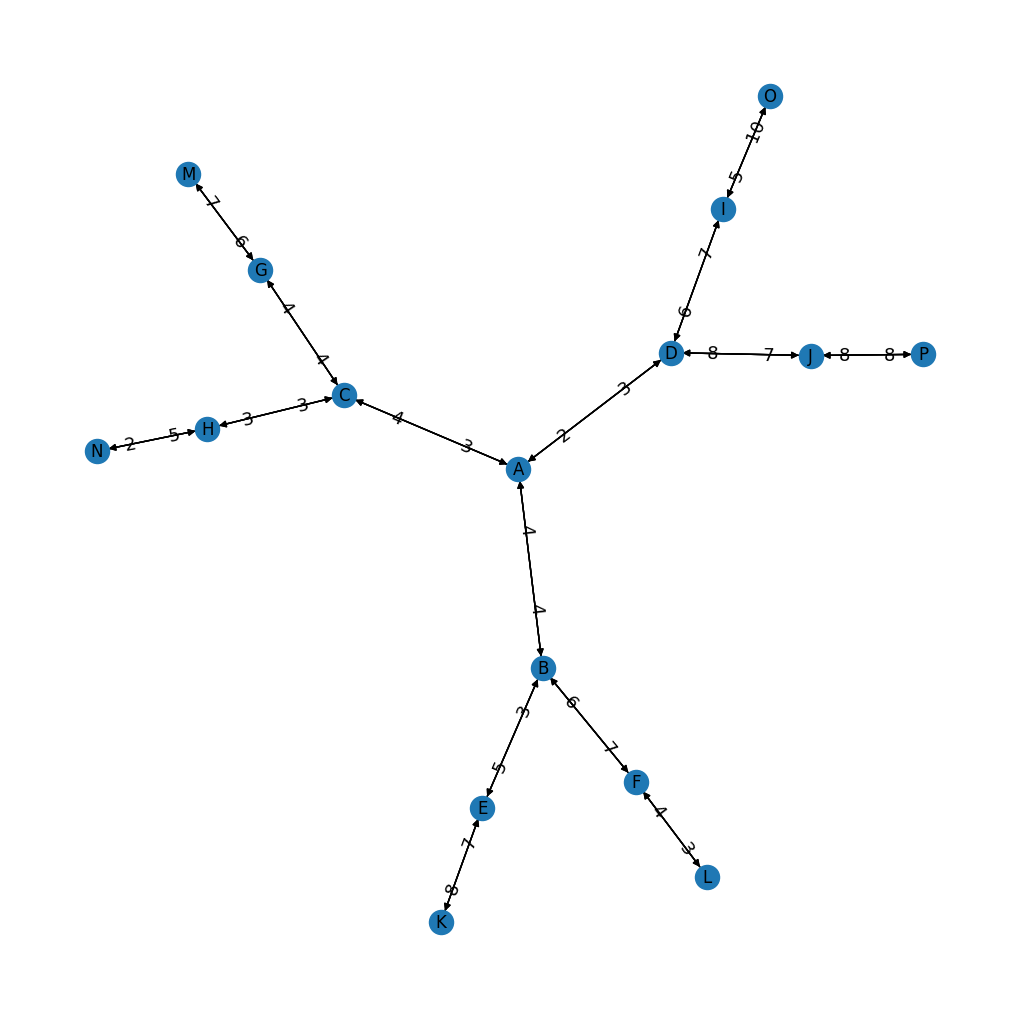

In [14]:
#Graph figure settings
plt.figure(figsize=(10, 10))
nx.draw(G, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos, labels, label_pos=0.7,  bbox=dict(alpha=0), font_size=13
)
nx.draw_networkx_edges(G, pos, arrows=True)
plt.savefig("undirected_digraphFromDict.png", dpi=400)
plt.show()

##
*Testing flow algorithm*
##

In [10]:
graph_dict2 = {
    "A": {"B": {"volume": "?"}, "C": {"volume": 3},   "D": {"volume": 2}, "Q": {"volume": 10} },
    "B": {"A": {"volume": "?"}, "E": {"volume": 3},   "F": {"volume": 6}},
    "C": {"A": {"volume": 4},   "G": {"volume": "?"}, "H": {"volume": 3}},
    "D": {"A": {"volume": 3},   "I": {"volume": 6},   "J": {"volume": 8}},
    "E": {"B": {"volume": 5},   "K": {"volume": 7}},
    "F": {"B": {"volume": 7},   "L": {"volume": 4}},
    "G": {"C": {"volume": "?"}, "M": {"volume": 6}},
    "H": {"C": {"volume": 3},   "N": {"volume": 5}, "Q": {"volume": 10}, "M": {"volume": 7}},
    "I": {"D": {"volume": 7},   "O": {"volume": 5}},
    "J": {"D": {"volume": 7},   "P": {"volume": 8}},
    "K": {"E": {"volume": 8}, "Q": {"volume": 3}},
    "L": {"F": {"volume": 3}, "M": {"volume": 4}},
    "M": {"G": {"volume": 7}, "H": {"volume": 4}, "L": {"volume": 5}},
    "N": {"H": {"volume": 2}},
    "O": {"I": {"volume": 10}},
    "P": {"J": {"volume": 8}},
    "Q": {"A": {"volume": 5}, "H": {"volume": 4}, "K": {"volume": 4}},
}


#When .5, always round up to nearest integer
def custom_round(value):
    return math.floor(value + 0.5) if value >= 0 else math.ceil(value - 0.5)

#Retrieves the neighbors of the current node
def get_connected_neighbors(graph_dict, node):
    connected_neighbors = list(graph_dict[node].keys())
    return connected_neighbors

#Function for calculating the mean between the neighbors of the edge where volume attribute is missing
def fill_missing_volume(graph_dict, node):
    connected_neighbors = get_connected_neighbors(graph_dict, node)

    for neighbor in connected_neighbors:
        if graph_dict[node][neighbor]["volume"] == "?":
            neighbor_connected_nodes = get_connected_neighbors(graph_dict, neighbor)
            volumes_from_node = []
            volumes_to_neighbor = []

            for n in connected_neighbors:
                if n != neighbor:
                    volumes_from_node.append(graph_dict[node][n]["volume"])

            for n in neighbor_connected_nodes:
                if n != node:
                    volumes_to_neighbor.append(graph_dict[neighbor][n]["volume"])

            volumes_from_node = [v for v in volumes_from_node if v != "?"]
            volumes_to_neighbor = [v for v in volumes_to_neighbor if v != "?"]

            avg_volume = custom_round((sum(volumes_from_node) + sum(volumes_to_neighbor)) / (len(volumes_from_node) + len(volumes_to_neighbor)))

            graph_dict[node][neighbor]["volume"] = avg_volume
            graph_dict[neighbor][node]["volume"] = avg_volume

# Fills the missing volumes in the graph_dict
for node in graph_dict:
    fill_missing_volume(graph_dict2, node)




In [11]:
# Saves graph_dict as json for further usage
with open("tesing_flow.json", "w") as f:
    json.dump(graph_dict2, f, indent=4)

In [12]:
# Creates an empty directed graph
F = nx.DiGraph()
nx.to_undirected(F)

In [13]:

# Iterating through the dictionary and add edges along with their attributes
for node, neighbors in graph_dict2.items():
    for neighbor, attributes in neighbors.items():
        F.add_edge(node, neighbor, **attributes)

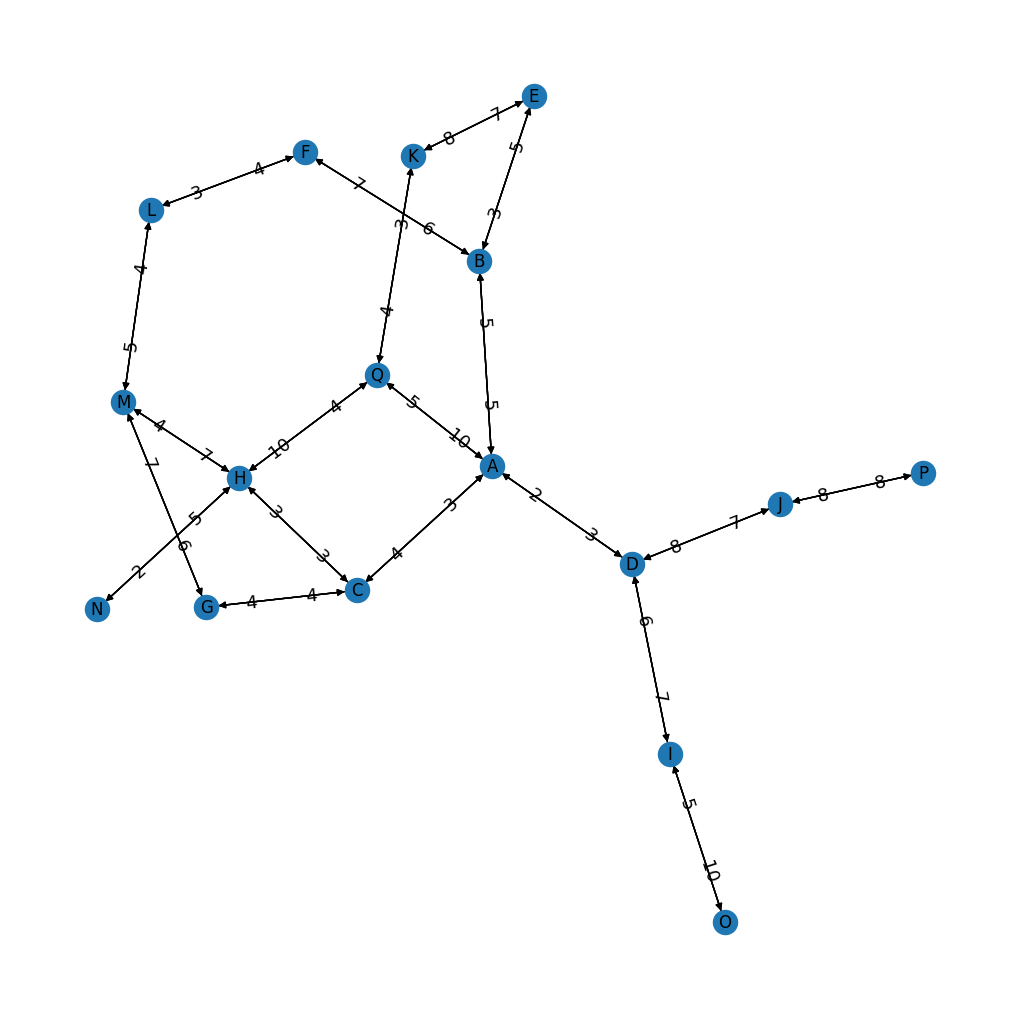

In [14]:
#Graph layout settings
pos = nx.kamada_kawai_layout(F)
#pos = nx.spring_layout(F, seed=13)

labels = {(u, v): data["volume"] for u, v, data in F.edges(data=True)}

#Graph figure settings
plt.figure(figsize=(10, 10))
nx.draw(F, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(
    F, pos, labels, label_pos=0.7,  bbox=dict(alpha=0), font_size=13
)
nx.draw_networkx_edges(F, pos, arrows=True)
plt.savefig("undirected_digraphFromDict.png", dpi=300)
plt.show()


In [ ]:
# Define the origin-destination pairs
OD_pairs = [("L", "O"), ("E", "G"), ("F", "P")]

# # Find the shortest path for each O-D pair
# for origin, destination in OD_pairs:
#     length, path = nx.bidirectional_dijkstra(F, origin, destination, weight="volume")
#     print(f"Shortest path from {origin} to {destination}: {path}")
#     print(f"Length of the shortest path: {length}")

# Find the shortest path for each O-D pair
for origin, destination in OD_pairs:
    length, path = nx.bidirectional_dijkstra(F, origin, destination, weight="volume")
    
    # Calculate the sum of the volumes in the correct direction for the path
    correct_direction_volume = 0
    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i + 1]
        volume = F[current_node][next_node]["volume"]
        correct_direction_volume += volume
    
    print(f"Shortest path from {origin} to {destination}: {path}")
    print(f"Length of the shortest path: {length}")
    print(f"Sum of volumes in the correct direction for the path: {correct_direction_volume}")


In [ ]:
# Find the shortest path for each O-D pair
""" for origin, destination in OD_pairs:
    length, path = nx.all_pairs_dijkstra_path_length(F, cutoff=None, weight="volume")
    
    # Calculate the sum of the volumes in the correct direction for the path
    correct_direction_volume = 0
    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i + 1]
        volume = F[current_node][next_node]["volume"]
        correct_direction_volume += volume
    
    print(f"Shortest path from {origin} to {destination}: {path}")
    print(f"Length of the shortest path: {length}")
    print(f"Sum of volumes in the correct direction for the path: {correct_direction_volume}") """

In [ ]:
# Define the graph as a dictionary
graph_dict = {
    "A": {"B": {"volume": "???"}, "C": {"volume": 3}, "D": {"volume": 2}},
    "B": {"A": {"volume": 6}, "E": {"volume": "???"}, "F": {"volume": 6}},
    "C": {"A": {"volume": 4}, "G": {"volume": 4}, "H": {"volume": 3}},
    "D": {"A": {"volume": "???"}, "I": {"volume": 6}, "J": {"volume": 8}},
    "E": {"B": {"volume": 5}, "K": {"volume": 7}},
    "F": {"B": {"volume": 7}, "L": {"volume": 4}},
    "G": {"C": {"volume": "???"}, "M": {"volume": 6}},
    "H": {"C": {"volume": 3}, "N": {"volume": 5}},
    "I": {"D": {"volume": 7}, "O": {"volume": "???"}},
    "J": {"D": {"volume": "???"}, "P": {"volume": "???"}},
    "K": {"E": {"volume": 8}},
    "L": {"F": {"volume": "???"}},
    "M": {"G": {"volume": 7}},
    "N": {"H": {"volume": "???"}},
    "O": {"I": {"volume": 10}},
    "P": {"J": {"volume": 8}},
}

# Save graph_dict as json for further usage
with open("graphJson.json", "w") as f:
    json.dump(graph_dict, f, indent=4)

# Create an empty directed graph
G = nx.DiGraph()

# Iterate through the dictionary and add edges along with their attributes
for node, neighbors in graph_dict.items():
    for neighbor, attributes in neighbors.items():
        G.add_edge(node, neighbor, **attributes)


pos = nx.spring_layout(G, seed=2)
labels = {x[:2]: G.get_edge_data(*x)["volume"] for x in G.edges}


plt.figure(figsize=(10, 10))
nx.draw(G, pos=pos, with_labels=True, connectionstyle="arc3, rad=0.1")
nx.draw_networkx_edge_labels(
    G, pos, labels, label_pos=0.3, bbox=dict(alpha=0), font_size=10
)
plt.savefig("digraphFromDict.png", dpi=400)
plt.show()